**同学的方法：**

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
np.random.seed(42)

In [2]:
df = pd.read_csv('homepage-experiment-data.csv')
df.shape

(29, 7)

In [3]:
df.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses
0,1,1764,246,1,1850,339,3
1,2,1541,234,2,1590,281,2
2,3,1457,240,1,1515,274,1
3,4,1587,224,1,1541,284,2
4,5,1606,253,2,1643,292,3


In [4]:
df['Control Pct'] = df['Control Downloads'] / df['Control Cookies']
df['Experiment Pct'] = df['Experiment Downloads'] / df['Experiment Cookies']
df["pct"] = (df['Control Downloads'] + df['Experiment Downloads']) / (df['Control Cookies'] + df['Experiment Cookies'])
df.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses,Control Pct,Experiment Pct,pct
0,1,1764,246,1,1850,339,3,0.139456,0.183243,0.161871
1,2,1541,234,2,1590,281,2,0.151849,0.176730,0.164484
2,3,1457,240,1,1515,274,1,0.164722,0.180858,0.172948
3,4,1587,224,1,1541,284,2,0.141147,0.184296,0.162404
4,5,1606,253,2,1643,292,3,0.157534,0.177724,0.167744


In [5]:
p_null = df.pct.mean()
print(p_null)

0.17096758178935728


In [6]:
n_diff =  np.mean(df['Experiment Pct'] - df['Control Pct'])
n_diff

0.01958488332359863

In [7]:
n_ctrl = np.mean(df['Control Cookies'])
n_exp = np.mean(df['Experiment Cookies'])

In [8]:
# simulate outcomes under null, compare to observed outcome
n_trials = 200_000

ctrl_clicks = np.random.binomial(n_ctrl, p_null, n_trials)
exp_clicks = np.random.binomial(n_exp, p_null, n_trials)

samples = exp_clicks / n_exp - ctrl_clicks / n_ctrl

samples

array([ 0.01114782, -0.00118655,  0.01490055, ...,  0.02575104,
       -0.01846632,  0.02029668])

In [9]:
print((samples >= n_diff).mean())

0.07078


**测试方法：**

In [10]:
# 读入数据
df = pd.read_csv('homepage-experiment-data.csv')

In [11]:
df['down_cpct'] = df['Control Downloads'] / df['Control Cookies']
df['down_epct'] = df['Experiment Downloads'] / df['Experiment Cookies']
df['down_diff'] = df['down_epct'] - df['down_cpct']
#df['down_diff'] = (df['Control Downloads'] + df['Experiment Downloads']) / (df['Control Cookies'] + df['Experiment Cookies'])
df.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses,down_cpct,down_epct,down_diff
0,1,1764,246,1,1850,339,3,0.139456,0.183243,0.043787
1,2,1541,234,2,1590,281,2,0.151849,0.176730,0.024880
2,3,1457,240,1,1515,274,1,0.164722,0.180858,0.016136
3,4,1587,224,1,1541,284,2,0.141147,0.184296,0.043149
4,5,1606,253,2,1643,292,3,0.157534,0.177724,0.020189


In [12]:
# 对两列差进行正态分布检验
import scipy.stats as stats

stats.normaltest(df['down_diff'],axis=0)
#结果是不正态分布，所以后续使用自助法（对数据分布无要求）

NormaltestResult(statistic=0.32437244363680806, pvalue=0.8502828485778031)

In [13]:
# 自助法
## 先设定要模拟的两列数据
con_mean, exp_mean = [], []

## 通过自助法模拟1w遍，记录并存储每一遍的mean值
for _ in range(10000):
    sample = df.sample(df.shape[0], replace=True)
    # 上面用了 df.shape[0] 定义 sample 的值（和实际值相同）
    con_mean.append(sample.down_cpct.mean())
    exp_mean.append(sample.down_epct.mean())

# 将两个值求差看diff
## 注意因为 list 无法做矢量减法，需要转换为 dataframe格式，也方便做图
diffs = pd.Series(con_mean) - pd.Series(exp_mean)
#当然也可以用 array 格式，看个人习惯
#diffs = np.array(con_mean) - np.array(incon_mean)

#diffs 也可以放在循环里面完成
#我个人习惯是放在之后计算，自助法只模拟原数据相关的featrue
#用自助法的好处是不用管样本的分布，因为取平均值后就是正态分布

-0.024476328908500173 -0.014639322580862995


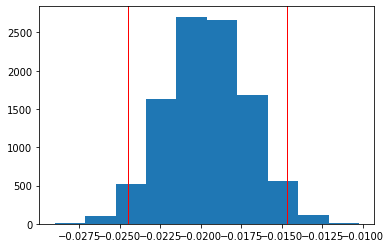

In [14]:
# 可视化
import matplotlib.pyplot as plt
%matplotlib inline

## 边界线
low, high = np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)
print(low, high)

## 画图
plt.hist(diffs);
plt.axvline(x=low, color='r', linewidth=1);
plt.axvline(x=high, color='r', linewidth=1);

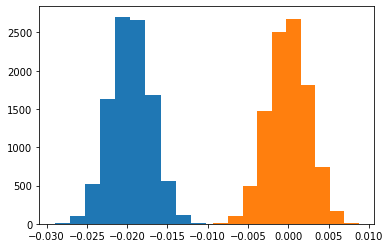

In [15]:
## 计算P值
null_diffs = np.random.normal(0, np.std(diffs), 10000)

plt.hist(diffs)
plt.hist(null_diffs);

In [16]:
p = (diffs > null_diffs).mean()
a = 0.5
significant = p < a

print(p, a, significant)

# 结果非常小，说明下载量的改善具有显著性

0.0 0.5 True


In [17]:
# 同样计算 License 购买量

df['lic_cpct'] = df['Control Licenses'] / df['Control Cookies']
df['lic_epct'] = df['Experiment Licenses'] / df['Experiment Cookies']
df['lic_diff'] = df['lic_epct'] - df['lic_cpct']
df.head()

,Day,Control Cookies,Control Downloads,Control Licenses,Experiment Cookies,Experiment Downloads,Experiment Licenses,down_cpct,down_epct,down_diff,lic_cpct,lic_epct,lic_diff
0,1,1764,246,1,1850,339,3,0.139456,0.183243,0.043787,0.000567,0.001622,0.001055
1,2,1541,234,2,1590,281,2,0.151849,0.176730,0.024880,0.001298,0.001258,-0.000040
2,3,1457,240,1,1515,274,1,0.164722,0.180858,0.016136,0.000686,0.000660,-0.000026
3,4,1587,224,1,1541,284,2,0.141147,0.184296,0.043149,0.000630,0.001298,0.000668
4,5,1606,253,2,1643,292,3,0.157534,0.177724,0.020189,0.001245,0.001826,0.000581


-0.0016839912069649015 0.0009207004702869716


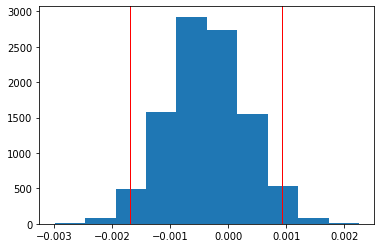

In [18]:
# 自助法
## 先设定要模拟的两列数据
con_mean, exp_mean = [], []

## 通过自助法模拟1w遍，记录并存储每一遍的mean值
for _ in range(10000):
    sample = df.sample(df.shape[0], replace=True)
    # 上面用了 df.shape[0] 定义 sample 的值（和实际值相同）
    con_mean.append(sample.lic_cpct.mean())
    exp_mean.append(sample.lic_epct.mean())

# 将两个值求差看diff
## 注意因为 list 无法做矢量减法，需要转换为 dataframe格式，也方便做图
diffs = pd.Series(con_mean) - pd.Series(exp_mean)
#当然也可以用 array 格式，看个人习惯
#diffs = np.array(con_mean) - np.array(incon_mean)

#diffs 也可以放在循环里面完成
#我个人习惯是放在之后计算，自助法只模拟原数据相关的featrue
#用自助法的好处是不用管样本的分布，因为取平均值后就是正态分布

# 可视化
import matplotlib.pyplot as plt
%matplotlib inline

## 边界线
low, high = np.percentile(diffs, 2.5), np.percentile(diffs, 97.5)
print(low, high)

## 画图
plt.hist(diffs);
plt.axvline(x=low, color='r', linewidth=1);
plt.axvline(x=high, color='r', linewidth=1);

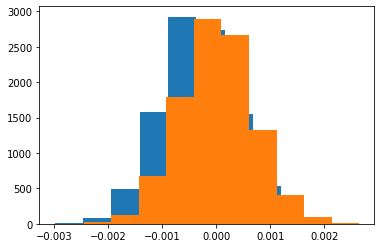

In [19]:
## 计算P值
null_diffs = np.random.normal(0, np.std(diffs), 10000)

plt.hist(diffs)
plt.hist(null_diffs);

In [20]:
p = (diffs > null_diffs).mean()
a = 0.05
significant = p < a

print(p, a, significant)

# P值较大，说明购买License的改善不具有显著性

0.3431 0.05 False
